# Cleaning "Mass Mobilizations" Protest Dataset

This notebook receives as input the raw edition of the Mass Mobilization protest dataset from the Mass Molilization Project and funded by the Political Instability Task Force (PITF). The notebook serves the purpose of addressing missing and inconsistent values, removing outliers, and creating consistent naming schemes to allow for cross-use with other datasets.


### About the Data
It is described in the source documentation as "an effort to understand citizen movements against governments, what citizens want when they demonstrate against governments, and how governments respond to citizens. The MM data cover 162 countries between 1990 and 2018. These data contain events where 50 or more protesters publicly demonstrate against government, resulting in more than 10,000 protest events. Each event records location, protest size, protester demands, and government responses." [(1)](https://massmobilization.github.io/about.html) The project is sponsored by the Political Instability Task Force (PITF). The PITF is funded by the Central Intelligence Agency (CIA). [(1)](https://massmobilization.github.io/about.html) Throughout the rest of this analysis, this dataset will be referred to as the "Protests" dataset.

Although the data source does specify that the dataset is not entirely comprehensive of all country across this entire time period. That said, it does contain over 17,000 recorded protests, each composed of 31 features. The data span 167 countries from 1990 to 2020. 


#### Data source citation:
Clark, David; Regan, Patrick, 2016, "Mass Mobilization Protest Data", https://doi.org/10.7910/DVN/HTTWYL, Harvard Dataverse, V5, UNF:6:F/k8KUqKpCa5UssBbL/gzg== [fileUNF]

## Data Understanding

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Exporting processed dataset
from sqlalchemy import create_engine

# Options
#pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
%matplotlib inline

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2

# Global constant
UNKNOWN = 'unknown'

In [2]:
# Import raw dataset in CSV format
path = '../data/raw/Mass-Mobilization-Protests/mmALL_073120_csv.csv'
df = pd.read_csv(path)

In [3]:
# Provide general descriptors of dataset
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17145 entries, 0 to 17144
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     17145 non-null  int64  
 1   country                17145 non-null  object 
 2   ccode                  17145 non-null  int64  
 3   year                   17145 non-null  int64  
 4   region                 17145 non-null  object 
 5   protest                17145 non-null  int64  
 6   protestnumber          17145 non-null  int64  
 7   startday               15239 non-null  float64
 8   startmonth             15239 non-null  float64
 9   startyear              15239 non-null  float64
 10  endday                 15239 non-null  float64
 11  endmonth               15239 non-null  float64
 12  endyear                15239 non-null  float64
 13  protesterviolence      15758 non-null  float64
 14  location               15218 non-null  object 
 15  pa

None

,id,ccode,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence
count,1.714500e+04,17145.000000,17145.000000,17145.000000,17145.000000,15239.000000,15239.000000,15239.000000,15239.000000,15239.000000,15239.000000,15758.000000
mean,4.380888e+09,437.888189,2006.171654,0.888831,7.406299,15.455935,6.227836,2006.326465,15.580616,6.243520,2006.329221,0.256060
std,2.320550e+09,232.054953,8.987378,0.314351,11.854041,8.817037,3.461912,8.958007,8.803944,3.461745,8.959254,0.436469
min,2.019900e+08,20.000000,1990.000000,0.000000,0.000000,1.000000,1.000000,1990.000000,1.000000,1.000000,1990.000000,0.000000
25%,2.202010e+09,220.000000,1998.000000,1.000000,1.000000,8.000000,3.000000,1999.000000,8.000000,3.000000,1999.000000,0.000000
50%,4.342008e+09,434.000000,2007.000000,1.000000,3.000000,15.000000,6.000000,2007.000000,16.000000,6.000000,2007.000000,0.000000
75%,6.512005e+09,651.000000,2014.000000,1.000000,8.000000,23.000000,9.000000,2014.000000,23.000000,9.000000,2014.000000,1.000000
max,9.102020e+09,910.000000,2020.000000,1.000000,143.000000,31.000000,12.000000,2020.000000,31.000000,12.000000,2020.000000,1.000000


##### Check for duplicated protest IDs

In [4]:
df.id.value_counts()

512000000     1
4502005006    1
2202017017    1
2001995002    1
1352011003    1
             ..
2202002009    1
2001998017    1
4901991003    1
6402014010    1
701995005     1
Name: id, Length: 17145, dtype: int64

##### Understand protest year

[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020]


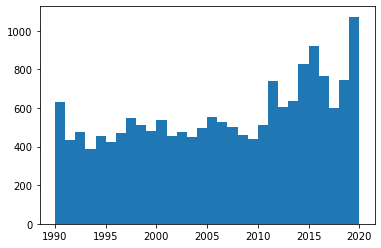

In [5]:
# Understand "Protest Year" feature
year = df.year.unique()
year.sort()
print(year)

plt.hist(df.year, bins=(2020-1990));

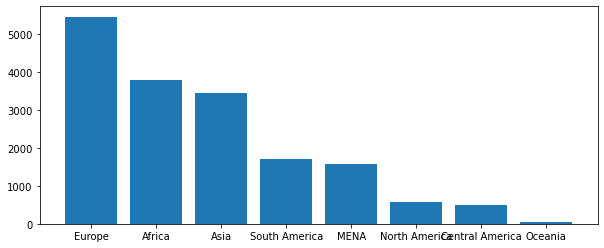

In [6]:
# Understand "Region" feature
regions = df.region.value_counts()
plt.figure(figsize=(10, 4))
plt.bar(regions.index, regions.values);

##### "Protest" feature is used to indicate whether or not a protest occurred. Drop all rows with df.protest == 0. This means no protest took place, which can be verified by investigating a sample of those entries. Since this analysis studies only protests, non-protest entries are not of interest.

In [7]:
print(df.protest.value_counts())

print('\nDropping {} rows'.format(df.protest.value_counts().iloc[1]))

df = df.loc[df.protest == 1].copy()
df.reset_index(inplace=True, drop=True)

1    15239
0     1906
Name: protest, dtype: int64

Dropping 1906 rows


1     2970
2     2141
3     1620
4     1269
5     1024
6      792
7      627
8      533
9      439
10     384
11     331
12     288
13     250
14     216
15     191
16     174
17     157
18     143
19     129
20     120
Name: protestnumber, dtype: int64


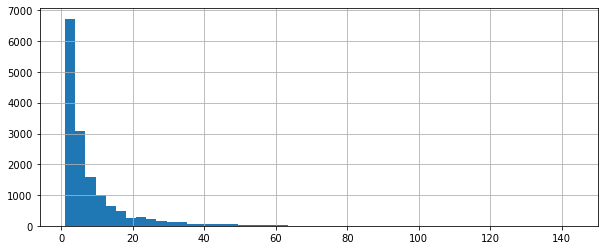

In [8]:
# Understand "ProtestNumber" feature
protestnumber = df.protestnumber.value_counts()
print(protestnumber[:20])

plt.figure(figsize=(10, 4))
df.protestnumber.hist(bins=50);

##### Is "year" column the same as "startyear" column? Yep!

In [9]:
df.loc[df.year != df.startyear]

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,location,participants_category,participants,protesteridentity,protesterdemand1,protesterdemand2,protesterdemand3,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes


In [10]:
df.protesterviolence.value_counts()

0.0    11204
1.0     4035
Name: protesterviolence, dtype: int64

##### "Location" feature has too many unique values to provide value to analysis (confirmed by further investigation into data) and isn't at all standardized. Drop feature.

In [11]:
print(f'{df.location.unique().shape[0]} unique locations')
df.drop('location', axis=1, inplace=True)

4401 unique locations


## Feature Engineering

#### Convert 'Start' and 'End' dates to their own datetime columns

In [12]:
# For start date
startdate = df[['startyear', 'startmonth', 'startday']]
startdate.columns = ['year', 'month', 'day']
df['startdate'] = pd.to_datetime(startdate)

# For end date
enddate = df[['endyear', 'endmonth', 'endday']]
enddate.columns = ['year', 'month', 'day']
df['enddate'] = pd.to_datetime(enddate)


# Duration
# Add 1 to enddate because no protest is "zero" days, as would be indicated by a 1-day protest in the otherwise-defined below formula
df['duration_days'] = ((df.enddate+datetime.timedelta(days=1)) - df.startdate).dt.days

#### Country name codes

Make consistent with other data sources to enable merging. Minor differences in spelling, abbreviations, casing, etc. make this necessary. Process completed in simple Excel file for simplicity. Import that lookup table to convert to new naming schemes.

In [13]:
# Import Excel file containing lookup mapping/dictionary
code_lookup = pd.read_excel('../src/country_codes_protests.xlsx')
name_dict  = dict(zip(code_lookup.combo_original, code_lookup.country_final))
scode_dict = dict(zip(code_lookup.combo_original, code_lookup.scode_final))

# Create ID to be used across all datasets
df['combo'] = df.country + '_' + df.ccode.astype('str')
df['countryname_final'] = df.combo.map(name_dict)
df['scode_final'] = df.combo.map(scode_dict)

# Show results
display(df[['country', 'ccode', 'combo', 'countryname_final', 'scode_final']].drop_duplicates())

# Drop unused/helper features
df.drop(['ccode', 'country', 'combo'], axis=1, inplace=True)

,country,ccode,combo,countryname_final,scode_final
0,Canada,20,Canada_20,Canada,CAN
53,Cuba,40,Cuba_40,Cuba,CUB
152,Haiti,41,Haiti_41,Haiti,HAI
275,Dominican Republic,42,Dominican Republic_42,Dominican Republic,DOM
346,Jamaica,51,Jamaica_51,Jamaica,JAM
...,...,...,...,...,...
14957,Singapore,830,Singapore_830,Singapore,SIN
14972,Philippines,840,Philippines_840,Philippines,PHI
15036,Indonesia,850,Indonesia_850,Indonesia,INS
15189,Timor Leste,860,Timor Leste_860,Timor Leste,ETM


### Fill in missing "Participants Category" value using the "Participants" column. 
This takes some manual  changes. Everything that can be changed from string to int is done automatically. Everything that can't be done automatically is added to a dictionary to be done manually. This *drastically* reduces any need for manual work

In [14]:
print(df.participants_category.value_counts())
print(f'\n{df.loc[df.participants.isna()].shape[0]} null values')

100-999       3204
50-99         2508
2000-4999     1580
>10000        1470
5000-10000     642
1000-1999      483
Name: participants_category, dtype: int64

12 null values


In [15]:
# Convert range in format "a-b" to average(a, b)
def convert_range_to_average(range_string):

    if range_string is np.nan:
        return np.nan
    
    # Split "x-y" format
    range_list = str.split(range_string, '-')
    
    if len(range_list)==1:
        avg = range_list[0].replace('<', '').replace('>', '')
    
    elif len(range_list)==2:
        # Convert both "x" and "y" to ints before averaging
        avg = np.mean([int(range_list[0]), int(range_list[1])])
    
    else:
        raise error

    # Return average
    return int(avg)

In [16]:
# ----- CREATE 'CONVERTER' DICTIONARY -----
# also create dictionary of 'participant' values that couldn't be converted

# Gather array of unique 'participants' values
participants_unique = df.participants.dropna().unique()

# Create empty dictionaries to hold lookups
converter = {}

# Create dictionary to convert messy strings to ints
#print("COULDN'T CONVERT THE FOLLOWING VALUES:\n")
for participant in participants_unique:

    # Else remove commonly unnecessary characters
    participant_clean = str.lower(participant)\
                           .replace(',', '')\
                           .replace('about', '')\
                           .replace('around', '')\
                           .replace('over', '')\
                           .replace('people', '')\
                           .replace('some', '')\
                           .replace('estimated', '')\
                           .replace('protester', '')\
                           .replace('construction worker', '')\
                           .replace('member', '')\
                           .replace('citizen', '')\
                           .replace('parent', '')\
                           .replace('local', '')\
                           .replace('demonstrator', '')\
                           .replace('teacher', '')\
                           .replace('activist', '')\
                           .replace('supporter', '')\
                           .replace('villager', '')\
                           .replace('campaign', '')\
                           .replace('campaigner', '')\
                           .replace('driver', '')\
                           .replace('resident', '')\
                           .replace('participant', '')\
                           .replace(' of ', '')\
                           .replace('_', '')\
                           .replace(' to ', '-')\
                           .replace('>', '')\
                           .replace('<', '')\
                           .replace('+', '')\
                           .replace('almost','')\
                           .replace('more than','')\
                           .replace('less than', '')\
                           .replace('nearly', '')\
                           .replace('up to', '')\
                           .replace('at least', '')\
                           .replace('s', '')
    # Try converting clean value
    try:

        # Append to converter dictionary if successful
        converter[participant] = int(participant_clean)

    # Else convert values of format "x-y"
    except:
        try:

            converter[participant] = convert_range_to_average(participant_clean)

        # Else create dict to manually clean
        except:
            #print("Couldn't convert: {}  /  {}".format(participant, participant_clean))
            pass



In [17]:
# Identify the rows that weren't able to be converted using the dict above. 
# Estimate whether or not it is practical top use "participants_category"
# to average values within a range and use that value within participants_clean

temp = df[['id', 'participants', 'participants_category']].copy()
temp['participants_clean'] = df['participants'].map(converter)#.astype('Int64')

nas = temp.loc[temp['participants_clean'].isna()]
print('Remaining rows:', nas.shape[0])
print('Examples include:')


nas.sort_values(by='participants').head(100)

Remaining rows: 1291
Examples include:


,id,participants,participants_category,participants_clean
1410,1012017014,"""Rocked by protests""",100-999,NaN
11615,6601992002,.,NaN,NaN
1633,1302005002,.,NaN,NaN
11631,6602002005,.,NaN,NaN
15100,8501999009,.,NaN,NaN
...,...,...,...,...
1407,1012017011,Several thousand,2000-4999,NaN
5487,3432016002,Several thousand,5000-10000,NaN
14713,8002017001,Several thousand,2000-4999,NaN
1398,1012017002,Several thousand protesters,2000-4999,NaN


In [18]:
# Apply dictionary to convert original participant counts
counts_converted = df['participants'].map(converter)#.astype('Int64')

# Create a series to hold the averages converted from the range column
range_as_average = df['participants_category'].apply(convert_range_to_average)

# Choose the count value unless it is NaN, in which case use avg value
chose_non_nan = lambda avg, count: avg if math.isnan(float(count)) else count

# Apply dict
df['participants_clean'] = list(map(chose_non_nan, range_as_average, counts_converted))
print('Total remaining NaN values:', df['participants_clean'].isna().sum())

Total remaining NaN values: 14


In [19]:
df.describe()

,id,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,duration_days,participants_clean
count,1.523900e+04,15239.000000,15239.0,15239.000000,15239.000000,15239.000000,15239.000000,15239.000000,15239.000000,15239.000000,15239.000000,15239.000000,1.522500e+04
mean,4.315571e+09,2006.326465,1.0,8.332633,15.455935,6.227836,2006.326465,15.580616,6.243520,2006.329221,0.264781,2.607651,1.546013e+04
std,2.343174e+09,8.958007,0.0,12.262761,8.817037,3.461912,8.958007,8.803944,3.461745,8.959254,0.441231,15.839195,1.138397e+05
min,2.019900e+08,1990.000000,1.0,1.000000,1.000000,1.000000,1990.000000,1.000000,1.000000,1990.000000,0.000000,1.000000,1.000000e+01
25%,2.201993e+09,1999.000000,1.0,2.000000,8.000000,3.000000,1999.000000,8.000000,3.000000,1999.000000,0.000000,1.000000,1.000000e+02
50%,3.852015e+09,2007.000000,1.0,4.000000,15.000000,6.000000,2007.000000,16.000000,6.000000,2007.000000,0.000000,1.000000,5.000000e+02
75%,6.452015e+09,2014.000000,1.0,10.000000,23.000000,9.000000,2014.000000,23.000000,9.000000,2014.000000,1.000000,1.000000,3.000000e+03
max,9.102017e+09,2020.000000,1.0,143.000000,31.000000,12.000000,2020.000000,31.000000,12.000000,2020.000000,1.000000,939.000000,7.000000e+06


##### Fill in missing "Participant Categories" values from "Participants" feature

In [20]:
# Provide conversion from string formats to list formats
dict_str_to_list = {
    '50-99': [50, 99],
    '100-999': [100, 999],
    '2000-4999': [2000, 4999],
    '1000-1999': [1000, 1999],
    '5000-9999': [5000, 9999],
    '10000+': [10000, int(10e12)]}

dict_str_to_list

{'50-99': [50, 99],
 '100-999': [100, 999],
 '2000-4999': [2000, 4999],
 '1000-1999': [1000, 1999],
 '5000-9999': [5000, 9999],
 '10000+': [10000, 10000000000000]}

In [21]:
# Place each item in a given category
def pick_bucket(x):
    for key in dict_str_to_list:
        lim_low = dict_str_to_list[key][0]
        lim_hi  = dict_str_to_list[key][1]
        
        if (x >= lim_low) and (x <= lim_hi):
            return key
    return np.nan

df['participants_category_manufactured'] = list(map(pick_bucket, df['participants_clean']))
df['participants_category_manufactured'].value_counts()

100-999      4754
50-99        3475
10000+       2564
1000-1999    2489
2000-4999    1131
5000-9999     795
Name: participants_category_manufactured, dtype: int64

##### Now, check if the above categories match the Categories column in df as a QC

In [22]:
df_participants = df[['participants_category', 'participants', 'participants_clean', 'participants_category_manufactured']]
df_participants

,participants_category,participants,participants_clean,participants_category_manufactured
0,NaN,1000s,1000.0,1000-1999
1,NaN,1000,1000.0,1000-1999
2,NaN,500,500.0,100-999
3,NaN,100s,100.0,100-999
4,NaN,950,950.0,100-999
...,...,...,...,...
15234,100-999,100+,100.0,100-999
15235,1000-1999,About 1000,1000.0,1000-1999
15236,50-99,50+,50.0,50-99
15237,50-99,50+,50.0,50-99


##### Find values where the "manufactured" value (created from "Participants" column) is different from the "original" (provided) column

In [23]:
df_participants.loc[(df_participants.participants_category != df_participants.participants_category_manufactured) & 
                    (~df_participants.participants_category.isna()) & 
                    (df_participants.participants_category != '>10000')]\
                    .sort_values(by='participants', ascending=True)\
                    .value_counts()

participants_category  participants  participants_clean  participants_category_manufactured
2000-4999              1000s         1000.0              1000-1999                             879
5000-10000             thousands     7500.0              5000-9999                             137
                       5000          5000.0              5000-9999                             120
                       10000         10000.0             10000+                                 91
100-999                >50           50.0                50-99                                  69
                                                                                              ... 
5000-10000             6000-8000     7000.0              5000-9999                               1
                       6500          6500.0              5000-9999                               1
1000-1999              100s-1000s    550.0               100-999                                 1
5000-10000       

In [24]:
print(df.participants_clean.value_counts())
print('\nNA values:',df.participants_clean.isna().sum())

50.0       3172
100.0      2608
1000.0     2316
10000.0    1106
200.0       452
           ... 
950.0         1
87.0          1
12500.0       1
175.0         1
525.0         1
Name: participants_clean, Length: 318, dtype: int64

NA values: 14


In [25]:
# THIS SHOWS ALL PROTEXTS THAT HAVE EITHER COUNT OR CATEGORY AS MISSING
na_counts = df.loc[(df.participants_clean.isna()) |
                   (df.participants_category_manufactured.isna())]

print('Shape:', na_counts.participants_category.shape)
display(na_counts)

Shape: (31,)


,id,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,participants_category,participants,protesteridentity,protesterdemand1,protesterdemand2,protesterdemand3,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,startdate,enddate,duration_days,countryname_final,scode_final,participants_clean,participants_category_manufactured
21,202000004,2000,North America,1,4,16.0,6.0,2000.0,16.0,6.0,2000.0,1.0,NaN,10s,anti poverty protesters,"political behavior, process",NaN,NaN,NaN,crowd dispersal,arrests,NaN,NaN,NaN,NaN,NaN,"1. world briefing the new york times, june 16,...",anti poverty protesters fought with the police...,2000-06-16,2000-06-16,1,Canada,CAN,10.0,NaN
585,902005006,2005,Central America,1,6,16.0,3.0,2005.0,16.0,3.0,2005.0,1.0,NaN,NaN,NaN,"political behavior, process",NaN,NaN,NaN,crowd dispersal,NaN,NaN,NaN,NaN,NaN,NaN,world briefing americas: guatemala: protesters...,eighth day of protests over trade agreement wi...,2005-03-16,2005-03-16,1,Guatemala,GUA,NaN,NaN
770,921997001,1997,Central America,1,1,15.0,8.0,1997.0,15.0,8.0,1997.0,0.0,NaN,NaN,bank depositors,"political behavior, process",NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,swindled salvadorans demonstrate the philadelp...,protesters demand government refund losses fro...,1997-08-15,1997-08-15,1,El Salvador,SLV,NaN,NaN
781,922001001,2001,Central America,1,1,1.0,5.0,2001.0,1.0,5.0,2001.0,0.0,NaN,NaN,"unions, former guerrillas","political behavior, process",NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,"ap photos associated press international, may ...",unions and former guerrillas marched in protes...,2001-05-01,2001-05-01,1,El Salvador,SLV,NaN,NaN
783,922003001,2003,Central America,1,1,20.0,2.0,2003.0,20.0,2.0,2003.0,1.0,NaN,NaN,striking health care workers,labor wage dispute,NaN,NaN,NaN,crowd dispersal,NaN,NaN,NaN,NaN,NaN,NaN,protesters storm social security building in e...,striking health workers stormed el salvador s ...,2003-02-20,2003-02-20,1,El Salvador,SLV,NaN,NaN
794,922006004,2006,Central America,1,4,5.0,7.0,2006.0,5.0,7.0,2006.0,1.0,NaN,NaN,students,"price increases, tax policy",NaN,NaN,NaN,crowd dispersal,shootings,killings,arrests,NaN,NaN,NaN,"in el salvador, confrontation between police, ...",students protested increased prices in public ...,2006-07-05,2006-07-05,1,El Salvador,SLV,NaN,NaN
816,931994004,1994,Central America,1,4,23.0,8.0,1994.0,30.0,8.0,1994.0,1.0,NaN,NaN,transportation workers,"price increases, tax policy",NaN,NaN,NaN,crowd dispersal,NaN,NaN,NaN,NaN,NaN,NaN,nicaragua: transportation workers call nationa...,"transportation workers strike, protesting fuel...",1994-08-23,1994-08-30,8,Nicaragua,NIC,NaN,NaN
1633,1302005002,2005,South America,1,2,13.0,4.0,2005.0,13.0,4.0,2005.0,0.0,NaN,.,indians,"political behavior, process",NaN,NaN,NaN,crowd dispersal,NaN,NaN,NaN,NaN,NaN,NaN,"bbc monitoring latin america, april 13, 2005, ...",occupying the education ministry,2005-04-13,2005-04-13,1,Ecuador,ECU,NaN,NaN
11383,6452008002,2008,MENA,1,2,27.0,4.0,2008.0,27.0,4.0,2008.0,0.0,NaN,40,members of parliament,"political behavior, process",NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,iraq struggle unfolds in peaceful protest and ...,the latest episode in the struggle between the...,2008-04-27,2008-04-27,1,Iraq,IRQ,40.0,NaN
11419,6452013004,2013,MENA,1,4,26.0,1.0,2013.0,26.0,1.0,2013.0,1.0,NaN,NaN,sunnis,removal of politician,NaN,NaN,NaN,shootings,killings,NaN,NaN,NaN,NaN,NaN,deadly turn in protests against iraqi leadersh...,at least seven protesters and two soldiers wer...,2013-01-26,2013-01-26,1,Iraq,IRQ,NaN,NaN


##### The data manual says that only protests with 50+ people should be included. Below is the set of protests that do not meet that criterion. Drop those rows as outliers since they are inconsistent with the data definitions.

In [26]:
print('Before setting to NaN:')
display(df.loc[df.participants_clean < 50])

df.loc[df.participants_clean < 50, 'participants_clean'] = np.nan

Before setting to NaN:


,id,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,participants_category,participants,protesteridentity,protesterdemand1,protesterdemand2,protesterdemand3,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,startdate,enddate,duration_days,countryname_final,scode_final,participants_clean,participants_category_manufactured
21,202000004,2000,North America,1,4,16.0,6.0,2000.0,16.0,6.0,2000.0,1.0,NaN,10s,anti poverty protesters,"political behavior, process",NaN,NaN,NaN,crowd dispersal,arrests,NaN,NaN,NaN,NaN,NaN,"1. world briefing the new york times, june 16,...",anti poverty protesters fought with the police...,2000-06-16,2000-06-16,1,Canada,CAN,10.0,NaN
11383,6452008002,2008,MENA,1,2,27.0,4.0,2008.0,27.0,4.0,2008.0,0.0,NaN,40,members of parliament,"political behavior, process",NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,iraq struggle unfolds in peaceful protest and ...,the latest episode in the struggle between the...,2008-04-27,2008-04-27,1,Iraq,IRQ,40.0,NaN
11470,6511990002,1990,MENA,1,2,29.0,11.0,1990.0,29.0,11.0,1990.0,1.0,NaN,29,disgruntled voters,"political behavior, process",NaN,NaN,NaN,shootings,NaN,NaN,NaN,NaN,NaN,NaN,"ny times, nov. 29, 1990 section a; page 12; co...",the police reported that 29 people were injure...,1990-11-29,1990-11-29,1,Egypt,EGY,29.0,NaN
11793,6702012001,2012,MENA,1,1,9.0,3.0,2012.0,9.0,3.0,2012.0,0.0,NaN,10s,female students,social restrictions,NaN,NaN,NaN,crowd dispersal,beatings,NaN,NaN,NaN,NaN,NaN,woman dies after campus demonstration; religio...,one woman died as a result of the attack on pr...,2012-03-09,2012-03-09,1,Saudi Arabia,SAU,10.0,NaN
12145,7022012004,2012,Asia,1,4,6.0,9.0,2012.0,6.0,9.0,2012.0,0.0,NaN,10s,shopkeepers from korvon market,"political behavior, process",NaN,NaN,NaN,accomodation,NaN,NaN,NaN,NaN,NaN,NaN,1. shopkeepers protesting after market fire ne...,the shopkeepers protested to demand government...,2012-09-06,2012-09-06,1,Tajikistan,TAJ,10.0,NaN
12204,7032011001,2011,Asia,1,1,11.0,1.0,2011.0,11.0,1.0,2011.0,0.0,NaN,10s,members of patriotic movements,"political behavior, process",NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. kyrgyz patriots call for national tv channe...,1. protest centered on the demand for the publ...,2011-01-11,2011-01-11,1,Kyrgyzstan,KYR,10.0,NaN
12216,7032011013,2011,Asia,1,13,21.0,4.0,2011.0,21.0,4.0,2011.0,0.0,NaN,10s,united national movement government opposition,"political behavior, process",NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. kyrgyz opposition demands reform from gover...,a united national movement which claims to hav...,2011-04-21,2011-04-21,1,Kyrgyzstan,KYR,10.0,NaN
12222,7032011019,2011,Asia,1,19,21.0,6.0,2011.0,28.0,6.0,2011.0,0.0,NaN,10s,supporters of myrza asatov,"political behavior, process",NaN,NaN,NaN,arrests,NaN,NaN,NaN,NaN,NaN,NaN,1. kyrgyz protesters block road to tajikistan ...,the organizers of a road protest in lyaylyak d...,2011-06-21,2011-06-28,8,Kyrgyzstan,KYR,10.0,NaN
12238,7032012001,2012,Asia,1,1,12.0,1.0,2012.0,12.0,1.0,2012.0,0.0,NaN,10s,kyrgyz patriotic forces public movement,"political behavior, process",NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. kyrgyz protesters against plans to allow fo...,protestors were against allowing foreign compa...,2012-01-12,2012-01-12,1,Kyrgyzstan,KYR,10.0,NaN
12252,7032012015,2012,Asia,1,15,23.0,3.0,2012.0,23.0,3.0,2012.0,0.0,NaN,10s,the trade union,labor wage dispute,NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. kyrgyz trade union members rally against ne...,representatives of the trade union are holding...,2012-03-23,2012-03-23,1,Kyrgyzstan,KYR,10.0,NaN


##### Show the Participants distribution after cleaning is now complete

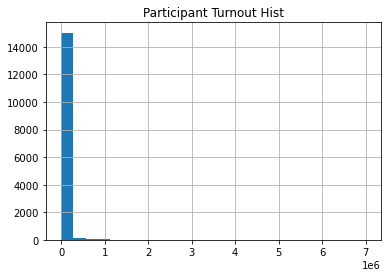

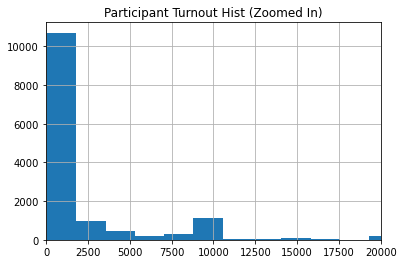

In [27]:
plt.figure()
df['participants_clean'].dropna().sort_values().hist(bins=25);
plt.title('Participant Turnout Hist')

plt.figure()
df['participants_clean'].dropna().sort_values().hist(bins=4000)
plt.xlim([0, 20000])
plt.title('Participant Turnout Hist (Zoomed In)');

#### Protester Identity

Drop this feature given the extreme number of unique values and lack of standardization

In [28]:
print(df.protesteridentity.value_counts().head(20))
print('\nUnique values:', df.protesteridentity.unique().shape[0])
df.drop('protesteridentity', axis=1, inplace=True)

protesters                                                         1541
students                                                            646
workers                                                             273
unspecified                                                         224
farmers                                                             219
residents                                                           171
opposition supporters                                               165
university students                                                 144
demonstrators                                                       137
opposition                                                          133
women                                                               115
teachers                                                             99
ladies in white                                                      90
people                                                          

### Protester Demands

There are 7 possible demand categories, as stated by the data dictionary. These features are provided in a difficult to use format and need to instead be one-hot encoded. Currently, there are four column for demands for each protest. There can be 1, 2, 3, or 4 demands, but there is not a dedicated column for each demand. The below process one-hot encodes the data to make it usable in models. 

In [29]:
# Columns to be used for this section
demand_cols = ['protesterdemand1', 'protesterdemand2', 'protesterdemand3', 'protesterdemand4']

# Print list of demands in each relevant column
for col in demand_cols:    
    print(df[col].value_counts())
    print('-----')

political behavior, process    9680
labor wage dispute             1710
price increases, tax policy    1087
removal of politician          1011
police brutality                825
land farm issue                 467
social restrictions             458
Name: protesterdemand1, dtype: int64
-----
political behavior, process    1004
removal of politician           768
labor wage dispute              438
police brutality                241
price increases, tax policy     214
social restrictions             212
land farm issue                 100
Name: protesterdemand2, dtype: int64
-----
price increases, tax policy    111
removal of politician           94
political behavior, process     63
labor wage dispute              61
police brutality                28
social restrictions             14
land farm issue                 12
Name: protesterdemand3, dtype: int64
-----
.                              744
removal of politician           18
police brutality                 7
land farm issue  

In [30]:
# Create list of unique demands
demands = np.concatenate([df.protesterdemand1.dropna().unique(), 
                          df.protesterdemand2.dropna().unique(),
                          df.protesterdemand3.dropna().unique(), 
                          df.protesterdemand4.dropna().unique()])
# Verify there are only 7 demands as indicated by data manual
set(demands)

{'.',
 'labor wage dispute',
 'land farm issue',
 'police brutality',
 'political behavior, process',
 'price increases, tax policy',
 'removal of politician',
 'social restrictions'}

In [31]:
# Replace '.' with np.nan
for demand_col in demand_cols:
    df[demand_col].replace('.', np.nan, inplace=True)

##### Create one-hot encoded columns for each of these demands

In [32]:
# Instantiate encoder
ohe = OneHotEncoder(sparse=False)

# Loop over all demands
for demand_col in demand_cols:
    
    # First iteration
    if demand_col == demand_cols[0]: 
        fit = ohe.fit_transform(df[demand_col].values.reshape(-1, 1))
        demand_array = np.array(fit)
    
    # Subsequent iterations
    else:
        fit = ohe.transform(df[demand_col].values.reshape(-1, 1))
        demand_array = np.logical_or(demand_array, fit)
        

# Clean column names
remove_commas = lambda x: str.replace(x, ', ', '/')
remove_spaces = lambda x: str.replace(x, ' ', '-')
col_names = ohe.get_feature_names(['demand'])
col_names = list(map(remove_spaces, map(remove_commas, col_names)))

# Store as dataframe 
demand_df = pd.DataFrame(demand_array, dtype='int', columns=col_names)
demand_df.drop('demand_nan', axis=1, inplace=True)

print('\nFinal shape:', demand_df.shape)
print('\nColumn names:', demand_df.columns)
print('\nRequests by type:\n{}'.format((demand_df.sum().sort_values(ascending=False))))


Final shape: (15239, 7)

Column names: Index(['demand_labor-wage-dispute', 'demand_land-farm-issue',
       'demand_police-brutality', 'demand_political-behavior/process',
       'demand_price-increases/tax-policy', 'demand_removal-of-politician',
       'demand_social-restrictions'],
      dtype='object')

Requests by type:
demand_political-behavior/process    10750
demand_labor-wage-dispute             2211
demand_removal-of-politician          1889
demand_price-increases/tax-policy     1414
demand_police-brutality               1101
demand_social-restrictions             684
demand_land-farm-issue                 582
dtype: int64


### State responses

These features are stored in the same format as the *protester demands* columns discussed above. The below cells use a similar one-hot encoding loop process to turn the demands into 7 one-hot encoded columns

In [33]:
# column names containing state response data
response_cols = ['stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4', 
             'stateresponse5', 'stateresponse6', 'stateresponse7']

# Replace '.' with np.nan
for col in response_cols:
    df[col].replace('.', np.nan, inplace=True)

In [34]:
# Verify there are only 7 responses as indicated by data manual
# Create list of unique demands

demands = np.array([])
for col in response_cols:
    demands = np.concatenate([demands, df[col]])
print(set(demands))
# We see that there are 7 demands, plus placeholder '.' and 'nan' values to drop later

{nan, 'arrests', 'beatings', 'shootings', 'killings', 'crowd dispersal', 'ignore', 'accomodation'}


In [35]:
# Encode each response

# Instantiate enocder
ohe = OneHotEncoder(sparse=False)

# Loop over each response column in the DataFrame
for col in response_cols:
    
    # First iteration
    if col == response_cols[0]: 
        fit = ohe.fit_transform(df[col].values.reshape(-1, 1))
        response_array = np.array(fit)     
    else:
        fit = ohe.transform(df[col].values.reshape(-1, 1))
        response_array = np.logical_or(response_array, fit)


print('\nPre-cleaning column names:', ohe.get_feature_names(['response']))
        
        
# # Clean column names
remove_spaces = lambda x: str.replace(x, ' ', '-')
col_names = ohe.get_feature_names(['response'])
col_names = list(map(remove_spaces, col_names))
print('\nPost-cleaning column names:', col_names)

# Store as dataframe 
response_df = pd.DataFrame(response_array, dtype='int', columns=col_names)
response_df.drop('response_nan', axis=1, inplace=True)

print('\nFinal shape:', response_df.shape)
print('\nColumn names:', response_df.columns)


Pre-cleaning column names: ['response_accomodation' 'response_arrests' 'response_beatings'
 'response_crowd dispersal' 'response_ignore' 'response_killings'
 'response_shootings' 'response_nan']

Post-cleaning column names: ['response_accomodation', 'response_arrests', 'response_beatings', 'response_crowd-dispersal', 'response_ignore', 'response_killings', 'response_shootings', 'response_nan']

Final shape: (15239, 7)

Column names: Index(['response_accomodation', 'response_arrests', 'response_beatings',
       'response_crowd-dispersal', 'response_ignore', 'response_killings',
       'response_shootings'],
      dtype='object')


### Investigate "sources" and "notes" columns

After close investigation, they are both filled with too many unique, unstandardized values to retain in analysis. Drop each of them.

In [36]:
print(f'{df.sources.unique().shape[0]} unique values, including:\n')
print(df.sources.value_counts())
df.drop('sources', axis=1, inplace=True)

14123 unique values, including:

germany s car capital reels as court allows ban on cars the new york times, february 28, 2018 wednesday, section a; column 0; foreign desk; pg. 1, 1583 words, by katrin bennhold ;                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    48
discontent over migrants takes a toll on east german city the new york times, december 2, 2015 wednesday, section ; column 0; foreign desk; l

In [37]:
print(f'{df.notes.unique().shape[0]} unique values, including:\n')
print(df.notes.value_counts())
df.drop('notes', axis=1, inplace=True)

13922 unique values, including:

general strike                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Put it all together

In [38]:
# Take a look at everything that is an option
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15239 entries, 0 to 15238
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  15239 non-null  int64         
 1   year                                15239 non-null  int64         
 2   region                              15239 non-null  object        
 3   protest                             15239 non-null  int64         
 4   protestnumber                       15239 non-null  int64         
 5   startday                            15239 non-null  float64       
 6   startmonth                          15239 non-null  float64       
 7   startyear                           15239 non-null  float64       
 8   endday                              15239 non-null  float64       
 9   endmonth                            15239 non-null  float64       
 10  endyear               

In [39]:
# Manually select only the features deemed worth keeping based on above analysis
include_cols = ['countryname_final', 'scode_final', 'region', 'protestnumber', 
                'protesterviolence', 'startdate', 'duration_days', 
                'participants_clean', 'participants_category_manufactured']

df[include_cols]

,countryname_final,scode_final,region,protestnumber,protesterviolence,startdate,duration_days,participants_clean,participants_category_manufactured
0,Canada,CAN,North America,1,0.0,1990-01-15,1,1000.0,1000-1999
1,Canada,CAN,North America,2,0.0,1990-06-25,1,1000.0,1000-1999
2,Canada,CAN,North America,3,0.0,1990-07-01,1,500.0,100-999
3,Canada,CAN,North America,4,1.0,1990-07-12,57,100.0,100-999
4,Canada,CAN,North America,5,1.0,1990-08-14,2,950.0,100-999
...,...,...,...,...,...,...,...,...,...
15234,Papua New Guinea,PNG,Oceania,1,1.0,2014-02-16,3,100.0,100-999
15235,Papua New Guinea,PNG,Oceania,1,1.0,2016-05-15,26,1000.0,1000-1999
15236,Papua New Guinea,PNG,Oceania,1,0.0,2017-06-15,1,50.0,50-99
15237,Papua New Guinea,PNG,Oceania,2,1.0,2017-07-15,1,50.0,50-99


### Combine clean dataframe with protester demands and government responses

In [40]:
df_joined = pd.concat([df[include_cols], demand_df, response_df], axis=1)

In [41]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15239 entries, 0 to 15238
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   countryname_final                   15239 non-null  object        
 1   scode_final                         15239 non-null  object        
 2   region                              15239 non-null  object        
 3   protestnumber                       15239 non-null  int64         
 4   protesterviolence                   15239 non-null  float64       
 5   startdate                           15239 non-null  datetime64[ns]
 6   duration_days                       15239 non-null  int64         
 7   participants_clean                  15208 non-null  float64       
 8   participants_category_manufactured  15208 non-null  object        
 9   demand_labor-wage-dispute           15239 non-null  int32         
 10  demand_land-farm-issue

### Fill na values where valuable, drop rows with remaining nas

Below, we see that there are 31 rows with null values. In all cases, it is in the 'participants' category. It is worth dropping these rows entirely since the participant count at a protest is an invaluable field in this analysis. 

In [42]:
display(df_joined.loc[df_joined.isna().any(axis=1)].info())

df_joined.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 21 to 15100
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   countryname_final                   31 non-null     object        
 1   scode_final                         31 non-null     object        
 2   region                              31 non-null     object        
 3   protestnumber                       31 non-null     int64         
 4   protesterviolence                   31 non-null     float64       
 5   startdate                           31 non-null     datetime64[ns]
 6   duration_days                       31 non-null     int64         
 7   participants_clean                  0 non-null      float64       
 8   participants_category_manufactured  0 non-null      object        
 9   demand_labor-wage-dispute           31 non-null     int32         
 10  demand_land-farm-issue  

None

##### Loop over list of columns to make sure the intended columns have been retained vs. deleted

In [43]:
keeper_cols = list(df_joined.columns)

for x_val in list(df.columns):
    incl = 'include:' if x_val in keeper_cols else '*EXCLUDE*:'
    print(incl, x_val)

*EXCLUDE*: id
*EXCLUDE*: year
include: region
*EXCLUDE*: protest
include: protestnumber
*EXCLUDE*: startday
*EXCLUDE*: startmonth
*EXCLUDE*: startyear
*EXCLUDE*: endday
*EXCLUDE*: endmonth
*EXCLUDE*: endyear
include: protesterviolence
*EXCLUDE*: participants_category
*EXCLUDE*: participants
*EXCLUDE*: protesterdemand1
*EXCLUDE*: protesterdemand2
*EXCLUDE*: protesterdemand3
*EXCLUDE*: protesterdemand4
*EXCLUDE*: stateresponse1
*EXCLUDE*: stateresponse2
*EXCLUDE*: stateresponse3
*EXCLUDE*: stateresponse4
*EXCLUDE*: stateresponse5
*EXCLUDE*: stateresponse6
*EXCLUDE*: stateresponse7
include: startdate
*EXCLUDE*: enddate
include: duration_days
include: countryname_final
include: scode_final
include: participants_clean
include: participants_category_manufactured


## Minor cleanups

##### Type casting

In [44]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15208 entries, 0 to 15238
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   countryname_final                   15208 non-null  object        
 1   scode_final                         15208 non-null  object        
 2   region                              15208 non-null  object        
 3   protestnumber                       15208 non-null  int64         
 4   protesterviolence                   15208 non-null  float64       
 5   startdate                           15208 non-null  datetime64[ns]
 6   duration_days                       15208 non-null  int64         
 7   participants_clean                  15208 non-null  float64       
 8   participants_category_manufactured  15208 non-null  object        
 9   demand_labor-wage-dispute           15208 non-null  int32         
 10  demand_land-farm-issue

In [45]:
# Convert relevant columns from float to int
convert_to_int = ['protesterviolence', 'participants_clean']

df.dropna(inplace=True)
for col in convert_to_int:
    df_joined[col] = df_joined[col].astype('int')

df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15208 entries, 0 to 15238
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   countryname_final                   15208 non-null  object        
 1   scode_final                         15208 non-null  object        
 2   region                              15208 non-null  object        
 3   protestnumber                       15208 non-null  int64         
 4   protesterviolence                   15208 non-null  int32         
 5   startdate                           15208 non-null  datetime64[ns]
 6   duration_days                       15208 non-null  int64         
 7   participants_clean                  15208 non-null  int32         
 8   participants_category_manufactured  15208 non-null  object        
 9   demand_labor-wage-dispute           15208 non-null  int32         
 10  demand_land-farm-issue

##### Add identifier to cross-reference with other datasets

In [46]:
# Add identifier
df_joined['year_scode'] = df_joined.startdate.dt.year.astype('str') + '_' + df_joined.scode_final

##### Rename columns for intuitive names when used externally (outside of this context)

In [47]:
df_joined.rename(columns={
    'participants_clean': 'participants', 
    'participants_category_manufactured': 'participants_category',
    'scode_final': 'scode',
    'countryname_final': 'country'}, inplace=True)
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15208 entries, 0 to 15238
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   country                            15208 non-null  object        
 1   scode                              15208 non-null  object        
 2   region                             15208 non-null  object        
 3   protestnumber                      15208 non-null  int64         
 4   protesterviolence                  15208 non-null  int32         
 5   startdate                          15208 non-null  datetime64[ns]
 6   duration_days                      15208 non-null  int64         
 7   participants                       15208 non-null  int32         
 8   participants_category              15208 non-null  object        
 9   demand_labor-wage-dispute          15208 non-null  int32         
 10  demand_land-farm-issue            

##### Final EDA of Response columns

## Remove Outliers

Now that the features have been selected and narrowed, the following section removes outliers.

#### Participants
Based on the histogram / KDE plot, there are clearly substantial outliers. None of these rows should be dropped simply because there is a large number of protesters, even if the values are extreme. Methodology: Replace upper extreme values with *3 x std + mean*

Replace outliers with: 357183
Number of affected values: 142


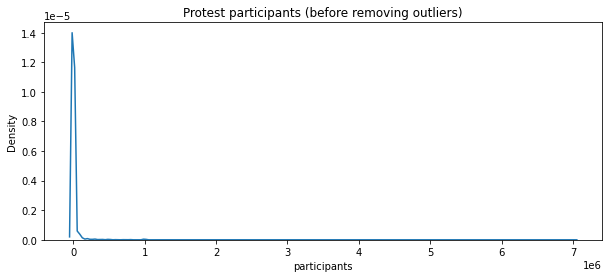

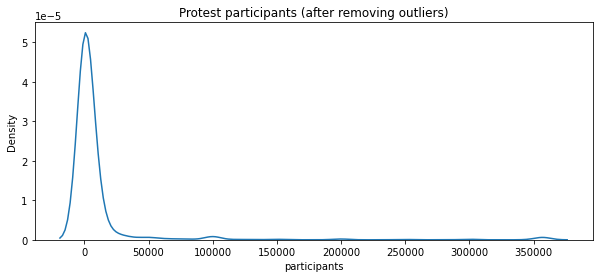

In [48]:
# Calculate the replacement value
max_value = int(df_joined.participants.mean() + 3*df_joined.participants.std())
print('Replace outliers with:', max_value)
print('Number of affected values:', df_joined.loc[df_joined.participants>max_value].shape[0])

# Before removing outliers
plt.figure(figsize=(10, 4))
sns.kdeplot(x=df_joined.participants)
plt.title('Protest participants (before removing outliers)')
plt.show()

# After removing outliers
df_joined.loc[df_joined.participants>max_value, 'participants'] = max_value
plt.figure(figsize=(10, 4))
sns.kdeplot(x=df_joined.participants)
plt.title('Protest participants (after removing outliers)');

#### Protest durations
As can be seen below, only ~13% of protests last longer than one day. As a result, if we're looking for outliers, the analysis will look at 3 times the standard deviation *after* removing the 1-day protests given how they skew the dataset. 

After removing those 1-day protests from consideration, the same approach for outliers will be applied as was done for the number of participants

In [49]:
print('Protests lasting one day:', (df_joined.duration_days == 1).sum())
print('Protests lasting longer:',  (df_joined.duration_days != 1).sum())
print('Percentage lasting longer:', (df_joined.duration_days != 1).sum()/(df_joined.duration_days != 0).sum())

Protests lasting one day: 13175
Protests lasting longer: 2033
Percentage lasting longer: 0.13367964229352972


Replace outliers with: 138
Number of affected values: 24


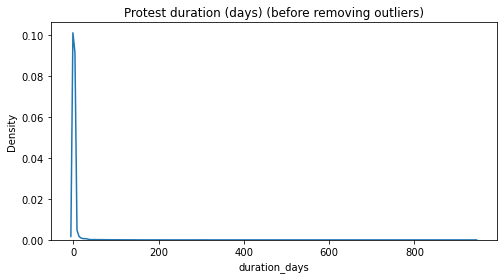

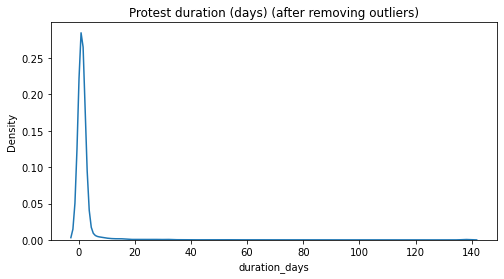

In [50]:
# Calculate the replacement value
remove_1_day_protests = df_joined.loc[df_joined.duration_days > 1, 'duration_days']
max_value = int(remove_1_day_protests.mean() + 3*remove_1_day_protests.std())
print('Replace outliers with:', max_value)
print('Number of affected values:', df_joined.loc[df_joined.duration_days>max_value].shape[0])


# Plot before removing outliers
plt.figure(figsize=(8, 4))
sns.kdeplot(x=df_joined.duration_days)
plt.title('Protest duration (days) (before removing outliers)')
plt.show()

# Calculate "max" threshold
df_joined.loc[df_joined.duration_days>max_value, 'duration_days'] = max_value

# Plot after removing outliers
plt.figure(figsize=(8, 4))
sns.kdeplot(x=df_joined.duration_days)
plt.title('Protest duration (days) (after removing outliers)');

### Protest number
Even the largest number of protests in a given year, 143, is very realistic even if it is an extreme outlier. Keep outliers as is.

Max protests per year: 143
Replace outliers with: 45
Number of affected values: 312


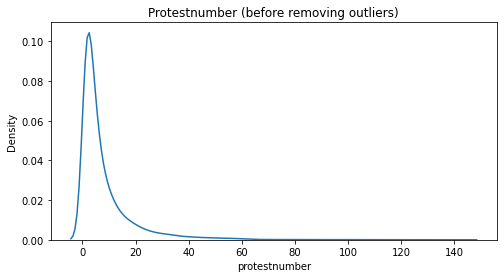

In [51]:
# Calculate the replacement value
max_value = int(df_joined.protestnumber.mean() + 3*df_joined.protestnumber.std())
print('Max protests per year:', df_joined['protestnumber'].max())
print('Replace outliers with:', max_value)
print('Number of affected values:', df_joined.loc[df_joined.protestnumber>max_value].shape[0])

# Plot before removing outliers
plt.figure(figsize=(8, 4))
sns.kdeplot(x=df_joined.protestnumber)
plt.title('Protestnumber (before removing outliers)')
plt.show()

# Export as SQL

In [52]:
# Response columns are not used in later portions of the analysis because they could lead to data leakage
response_cols = ['response_accomodation', 'response_arrests', 
                 'response_beatings', 'response_crowd-dispersal', 
                 'response_ignore', 'response_killings', 'response_shootings']

# Drop them
df_joined.drop(response_cols, axis=1, inplace=True)

In [53]:
# Export
engine = create_engine('sqlite:///../data/processed/protests.db')

with engine.begin() as connection:
    df_joined.to_sql(name='protests', 
                     con=engine, 
                     if_exists='replace', 
                     index=False)

#### Final dataset

In [54]:
display(df_joined.info())
df_joined.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15208 entries, 0 to 15238
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   country                            15208 non-null  object        
 1   scode                              15208 non-null  object        
 2   region                             15208 non-null  object        
 3   protestnumber                      15208 non-null  int64         
 4   protesterviolence                  15208 non-null  int32         
 5   startdate                          15208 non-null  datetime64[ns]
 6   duration_days                      15208 non-null  int64         
 7   participants                       15208 non-null  int32         
 8   participants_category              15208 non-null  object        
 9   demand_labor-wage-dispute          15208 non-null  int32         
 10  demand_land-farm-issue            

None

,protestnumber,protesterviolence,duration_days,participants,demand_labor-wage-dispute,demand_land-farm-issue,demand_police-brutality,demand_political-behavior/process,demand_price-increases/tax-policy,demand_removal-of-politician,demand_social-restrictions
count,15208.000000,15208.000000,15208.000000,15208.000000,15208.000000,15208.000000,15208.000000,15208.000000,15208.000000,15208.000000,15208.000000
mean,8.330155,0.264532,2.362770,10705.452459,0.145187,0.038204,0.072265,0.705484,0.092780,0.124145,0.044845
std,12.264161,0.441098,8.632436,43591.494343,0.352301,0.191694,0.258934,0.455840,0.290134,0.329758,0.206970
min,1.000000,0.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,500.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,10.000000,1.000000,1.000000,3000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,143.000000,1.000000,138.000000,357183.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
